# 고양이 수염 만들어주기

스노우나 스냅챗 등에서 얼굴에 필터를 씌워주는 것처럼 얼굴을 인식하고 특정 객채를 입혀보는 실습을 해보자.

- 얼굴 사진을 사용해서
- face landmark를 찾아내고
- 찾아진 영역에 고양이 수염 스티커를 붙여준다.

## Face landmark를 찾아주는 dlib

Object Detection, 물체 감지 기술을 이용해서 얼굴을 찾는다. 그중에 dlib의 face detector는 HOG와 SVM을 사용해서 얼굴을 찾는다.

- HOG : 이미지에서 색상의 변화량을 나타낸 방식으로 딥러닝 이전부터 인공지능 기술 향상에 도움을 줬다.
![이미지](https://scikit-image.org/docs/dev/_images/sphx_glr_plot_hog_001.png)


- SVM : 다차원의 표본공간의 구획을 나누는 백터들을 이용해서 분류하는 선형분류기다. 이번에는 얼굴인지 아닌지를 구분해주는 용도이다.
![SVM이미지](https://d3s0tskafalll9.cloudfront.net/media/images/e-8v2-3-2.max-800x600.png)

## face detector는 어떻게 얼굴을 찾을까?

[sliding window](https://ramees.tistory.com/52) 알고리즘을 이용해 의 HOG map을 일정 범위 씩 이동해가는 것이다. 콘볼루션의 필터와 비슷해보인다. 일정한 바코드 인식기를 쭉 왼쪽에서 오른쪽 위에서 아래로 훑는다는 느낌으로 얼굴만을 찾아낸다.

# 필요한 패키지 import 하기

In [1]:
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

# 인물 이미지 읽어오기

샘플 이미지를 읽어와서 출력해보자.

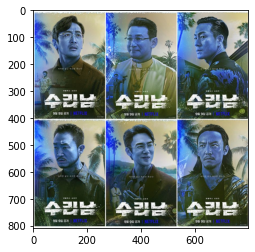

In [2]:
my_image_path = './images/surinam.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path,1)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

# bgr에서 rgb로 이미지형식 바꾸기

OpenCV 모듈의 imread는 png를 bgr색상의 형식으로 불러온다.
- 우리가 활용하는 dlib은 rgb 이미지를 입력으로 받는다.
- 우리가 입력한 이미지가 맞는지 확인하기 위해서도 rgb로 바꿔보자.

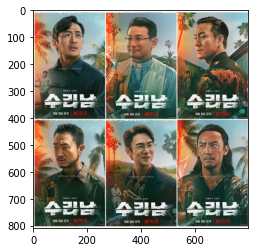

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

# dlib의 detector를 선언하자

In [4]:
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

In [5]:
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

작은 얼굴도 잘 탐지해내기 위해서 [이미지 피라미드](https://dsbook.tistory.com/219)를 사용하여 upsampling한다.

rectangles[[(318, 68) (426, 175)], [(593, 474) (700, 582)], [(364, 474) (454, 564)], [(91, 68) (199, 175)], [(55, 474) (163, 582)], [(569, 68) (677, 175)]]


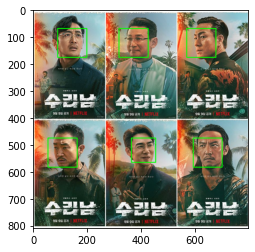

In [6]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 얼굴의 이목구비를 찾아내는 face landmark

얼굴의 이목구비의 위치를 추론해주는 기술을 face landmark localization이라 한다. 먼저 face detector로 찾은 bounding box 안에서 점을 찍으며, 얼굴의 윤곽을 찾아낸다.

![dlib landmark localization](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png)

## Object keypoint estimation 알고리즘

top-down : bounding box를 찾고 box 내부의 keypoint를 예측

bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

In [7]:
model_path = './models/shape_predictor_68_face_landmarks.dat'
    # 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [8]:
list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성    

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장
people_num = len(list_landmarks)
print(people_num)
print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

6
68


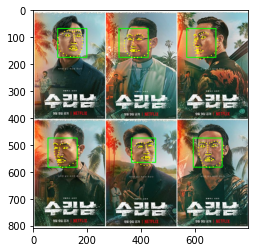

In [9]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

In [10]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(345, 98) (531, 284)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
# → [[(368, 153), (368, 174), (371, 195), (376, 215), (382, 235), (391, 252), (404, 266), (420, 277), (441, 279), (461, 276), (480, 266), (495, 252), (508, 235), (516, 216), (520, 195), (523, 173), (524, 151), (377, 131), (386, 119), (399, 116), (413, 118), (425, 124), (454, 121), (466, 114), (481, 112), (494, 114), (503, 127), (439, 143), (438, 156), (438, 169), (437, 182), (423, 197), (431, 199), (438, 200), (446, 199), (454, 197), (391, 147), (399, 142), (409, 143), (416, 149), (408, 150), (399, 150), (464, 147), (472, 141), (482, 141), (489, 145), (482, 149), (473, 149), (411, 227), (421, 222), (432, 218), (439, 220), (446, 218), (458, 222), (471, 227), (458, 234), (446, 238), (438, 238), (431, 238), (420, 235), (415, 227), (432, 227), (439, 228), (447, 227), (466, 227), (446, 228), (438, 229), (431, 228)]]

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[33]) # 코끝의 index는 33 입니다
    x = landmark[51][0] # 이미지에서 코 부위의 x값
    y = (landmark[33][1]+landmark[62][1])/2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(371, 138)
(x,y) : (372,143)
(w,h) : (109,109)
(648, 536)
(x,y) : (649,544)
(w,h) : (108,108)
(422, 533)
(x,y) : (420,540)
(w,h) : (91,91)
(152, 124)
(x,y) : (151,132)
(w,h) : (109,109)
(98, 545)
(x,y) : (99,551)
(w,h) : (109,109)
(609, 136)
(x,y) : (610,143)
(w,h) : (109,109)


(109, 109, 3)


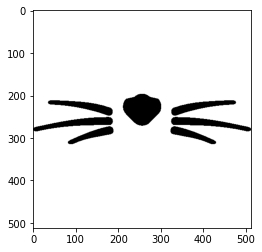

In [11]:
sticker_path = './images/cat-whiskers.png' # 고양이 수염 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환

plt.imshow(img_sticker)
plt.show


img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(109) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
print (img_sticker.shape) # 사이즈를 조정한 수염 이미지의 차원 확인

In [12]:
x

610

In [13]:
w

109

In [14]:
x - w //2

556

In [15]:
y - h //2

89.5

In [16]:
# x,y,w,h 모두 위에서 반복문 안에서 지정해준 값임
refined_x = x - w // 2 
refined_y = y - h // 2
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
# 즉, refined_x, refined_y값에서 수염 이미지가 시작됨
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) # 음수 발생 : 이미지 범위를 벗어남
# 우리는 인중 자리에 수염을 두고 싶다.
# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.

(x,y) : (556,89)


In [17]:
# 왕관 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# 현재 상황에서는 -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 아래와 같은 형식으로 나옵니다.
# 음수값 만큼 수염 이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (556,89)


In [18]:
img_sticker.shape[0]

109

In [19]:
refined_x

556

In [20]:
refined_y

89.5

In [21]:
refined_y = int(refined_y)

In [22]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

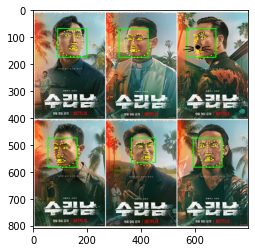

In [23]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

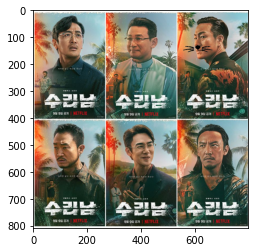

In [25]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.show()

# 회고

## 실습 초기에 발생한 문제
- 맥북이라서 그런건진 모르겠지만, 로컬에서 dlib이 깔리지 않았다.
- 여러 명의 얼굴에 필터가 동시에 입혀지지 않았다.
    - 반복문을 통해서 img_sticker의 객채별로 수염을 입혀줘야겠다.
- 인물의 각도에 따른 수염을 동작하도록 하지 못했다.
    - 이부분은 정확하게 해야 할 지 찾아봐야겠다.

## 실습간 느낀점
- dlib을 통해서 face detection이라는 걸 해봤는데, 모든 사람의 얼굴에 경계상자를 만들어 냈다. 하지만 황정민의 얼굴은 좀 넓게 잡아준 것은 아쉬웠다.

- 하지만 러프하게 잡아둔 얼굴 탐지 후, 정교하게 face landmark를 사용하니 놀라운 정확도를 보여줬다. 이정도 정확도로 추출해 내니까, 필터이미지의 모양도 조정할 수 있지 않을까 싶다.